# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

In [2]:
# Part 1
# features- 
train.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0


In [0]:
def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='Inspection ID')  # id is random
    X = X.drop(columns=['Address','City','State'])  # Address is random
    X = X.drop(columns=['AKA Name', 'DBA Name'])  # Duplicative of License
    X = X.drop(columns=['Latitude','Longitude','Location'])  # Duplicative of Zip
    X = X.drop(columns='Violations')  # high cardinality
    X = X.drop(columns='License #')  # high cardinality

    X['Facility Type'] = X['Facility Type'].str.lower()
    X['facility_restaurant'] = X['Facility Type'].str.contains('restaurant', na=False)
    X['facility_store'] = X['Facility Type'].str.contains('store', na=False)
    X['facility_school'] = X['Facility Type'].str.contains('school', na=False)
    X['facility_bakery'] = X['Facility Type'].str.contains('bakery', na=False)
    X['facility_daycare'] = X['Facility Type'].str.contains('daycare', na=False)
    X['facility_children'] = X['Facility Type'].str.contains('children', na=False)
    X['facility_daycare'] = X['Facility Type'].str.contains('daycare', na=False)
    X['facility_diner'] = X['Facility Type'].str.contains('diner', na=False)
    X['facility_food'] = X['Facility Type'].str.contains('food', na=False)
    X['facility_hospital'] = X['Facility Type'].str.contains('hospital', na=False)
    X['facility_tavern'] = X['Facility Type'].str.contains('tavern', na=False)
    X = X.drop(columns='Facility Type')

    X['Inspection Type'] = X['Inspection Type'].str.lower()
    X['Inspection_canvass'] = X.loc[:,'Inspection Type'] == 'canvass'
    X['Inspection_can_re'] = X.loc[:,'Inspection Type'] == 'canvass re-inspection'
    X['Inspection_license'] = X.loc[:,'Inspection Type'] == 'license'
    X['Inspection_lic_re'] = X.loc[:,'Inspection Type'] == 'license re-inspection'
    X['Inspection_complaint'] = X.loc[:,'Inspection Type'] == 'complaint'
    X['Inspection_com_re'] = X.loc[:,'Inspection Type'] == 'complaint re-inspection'
    X['Inspection_short_com'] = X.loc[:,'Inspection Type'] == 'short form complaint'
    X['Inspection_lic_force'] = X.loc[:,'Inspection Type'] == 'license-task force'
    X['Inspection_poison'] = X['Inspection Type'].str.contains('poisoning', na=False)
    X['Inspection_consult'] = X['Inspection Type'].str.contains('consultation', na=False)
    X['Inspection_tag'] = X.loc[:,'Inspection Type'] == 'tag removal'
    X['Inspection_out'] = X.loc[:,'Inspection Type'] == 'out of business'
    X['Inspection_liquor'] = X['Inspection Type'].str.contains('liquor', na=False)
    X = X.drop(columns='Inspection Type') 
    
    # Transform Risk High:1, Medium:2, Low:3
    X.loc[X['Risk'].str.contains("High", na=False), 'Risk'] = '1'
    X.loc[X['Risk'].str.contains("Medium", na=False), 'Risk'] = '2'
    X.loc[X['Risk'].str.contains("Low", na=False), 'Risk'] = '3'
    X = X.drop(columns='Risk')
    
   
    X['Inspection Date']= pd.to_datetime(X['Inspection Date'], infer_datetime_format=True).dt.month
    
    X['Zip']=X['Zip'].fillna(0)
    
    # Return the wrangled dataframe
    return X

In [4]:
X=wrangle(train)
X.head()

,Zip,Inspection Date,Fail,facility_restaurant,facility_store,facility_school,facility_bakery,facility_daycare,facility_children,facility_diner,...,Inspection_lic_re,Inspection_complaint,Inspection_com_re,Inspection_short_com,Inspection_lic_force,Inspection_poison,Inspection_consult,Inspection_tag,Inspection_out,Inspection_liquor
0,60657.0,9,1,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,60636.0,10,0,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,60649.0,4,0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,60632.0,4,0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,60629.0,1,0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# Part 2 Fit a Random Forest or Gradient Boosting model with the train set.
%%time
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

X1 = X.drop(columns='Fail')
y1 = X['Fail']

X_train, X_val, y_train, y_val = train_test_split(
    X1, y1, test_size=0.2, stratify=y1, random_state=42)


gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_proba = gb.predict_proba(X_val)[:,1]
print('Validation ROC AUC:', roc_auc_score(y_val, y_pred_proba))

Validation ROC AUC: 0.6800886859716964
CPU times: user 3.24 s, sys: 25.5 ms, total: 3.27 s
Wall time: 3.28 s


In [0]:
# Part 3
#Feature Importances
#Permutation Importances
#Partial Dependence Plot

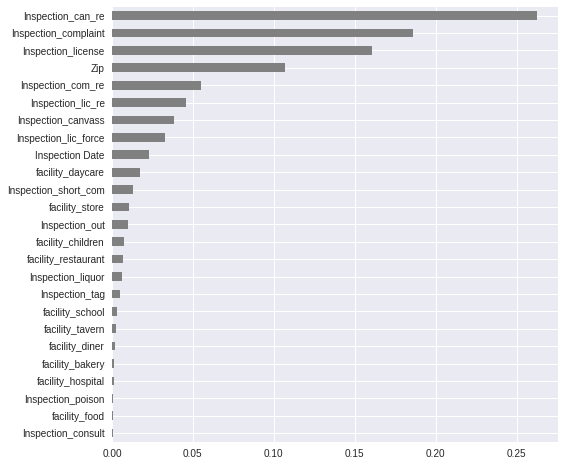

In [7]:
import matplotlib.pyplot as plt
import numpy as np


importances = pd.Series(gb.feature_importances_, X_train.columns)
top_n = importances.sort_values(ascending=False)
plt.figure(figsize=(8, 8))
top_n.sort_values().plot.barh(color='grey')

In [8]:
!pip install eli5

    100% |████████████████████████████████| 102kB 4.6MB/s 


In [15]:

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(gb, scoring='roc_auc', n_iter=1, cv=3)
permuter.fit(X_train, y_train)

ValueError: ignored

In [0]:
eli5.show_weights(permuter, top=None, feature_names=X_train.columns.tolist())

In [10]:
X_train[pd.isnull(X_train).any(axis=1)]

,Zip,Inspection Date,facility_restaurant,facility_store,facility_school,facility_bakery,facility_daycare,facility_children,facility_diner,facility_food,...,Inspection_lic_re,Inspection_complaint,Inspection_com_re,Inspection_short_com,Inspection_lic_force,Inspection_poison,Inspection_consult,Inspection_tag,Inspection_out,Inspection_liquor


In [11]:
%%time
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier

#encoder = ce.OrdinalEncoder()
#X_train_transformed = encoder.fit_transform(X_train)

model = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    min_samples_leaf=0.005, 
    n_jobs=-1)

model.fit(X_train, y_train)
permuter = PermutationImportance(model, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X_train, y_train)

CPU times: user 14.1 s, sys: 406 ms, total: 14.5 s
Wall time: 9.94 s


In [12]:
eli5.show_weights(permuter, top=None, feature_names=X_train.columns.tolist())

Weight,Feature
0.0516 ± 0.0000,Inspection_license
0.0424 ± 0.0000,Inspection_can_re
0.0379 ± 0.0000,Inspection_complaint
0.0159 ± 0.0000,Zip
0.0091 ± 0.0000,Inspection_com_re
0.0080 ± 0.0000,Inspection_lic_re
0.0054 ± 0.0000,Inspection_canvass
0.0047 ± 0.0000,Inspection Date
0.0034 ± 0.0000,facility_restaurant
0.0029 ± 0.0000,Inspection_short_com


In [13]:
!pip install pdpbox

    100% |████████████████████████████████| 57.7MB 479kB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


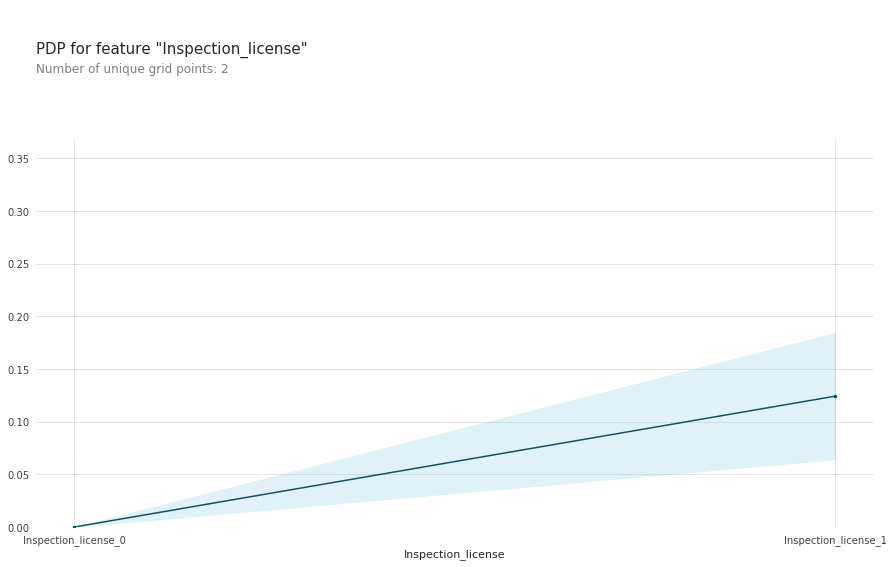

In [14]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='Inspection_license'
pdp_isolated = pdp_isolate(model=gb, dataset=X_train, model_features=X_train.columns, feature=feature)
pdp_plot(pdp_isolated, feature);